In [1]:
%load_ext autoreload

In [2]:
cd ..

/home/mars/Documents/src_aiai


In [3]:
%autoreload 2
%aimport src.visualisation

In [21]:
import numpy as np
import glob
from skimage import io, color
import matplotlib.pyplot as plt

In [5]:
from src.data import load_M51
from src.sampling.uv_sampling import spider_sampling
from src.operators.measurement import NUFFT_op
from src.solvers import PrimalDual_l1_constrained
from src.visualisation import compare
from src.operators.dictionary import wavelet_basis

In [6]:
def load_BSDS(i=0):
    files = glob.glob("./data/BSR/BSDS500/data/images/test/*.jpg")
    data = io.imread(files[i])[:256,:256]
    data = color.rgb2gray(data)
    return data

In [133]:
uv = spider_sampling()
# uv = np.vstack((uv, -uv))
m_op = NUFFT_op(uv)

In [134]:
uv.shape

(4440, 2)

In [135]:
dist = -1 * np.dot(uv, uv.T) -1 * np.dot(uv, uv.T).T + np.sum(uv**2, axis=1) + np.sum(uv**2, axis=1)[:,np.newaxis] # (x-y)'(x-y) = x'x + y'y - x'y -y'x
dist[dist < 0] = 0 # correct for numerical errors
gridsize = 2*np.pi/512
w = 1/np.sum(dist**.5 < gridsize, axis=1) # all pixels within 1 gridcell distance

In [137]:
x_true = load_BSDS()
y0 = m_op.dir_op(x_true)
ISNR = 50 #dB
sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
noise = np.random.normal(0, sigma, y0.shape) + 1j * np.random.normal(0, sigma, y0.shape)
y = y0 #+ noise

x_dirty = m_op.adj_op(y)
noise_val = np.std((m_op.adj_op(noise)))
x_filtered = m_op.adj_op(y*w)

In [138]:
x_true = load_BSDS()
k = 1
x_true = np.rot90(x_true, k=k)
y0 = m_op.dir_op(x_true)
ISNR = 50 #dB
# sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
# noise = np.random.normal(0, sigma, y0.shape) + 1j * np.random.normal(0, sigma, y0.shape)
y = y0 #+ noise
x_rot = np.rot90(m_op.adj_op(y*w),-k)
x_true = np.rot90(x_true, -k)

In [141]:
x_true = load_BSDS()
k = 1
x_true = np.fliplr(x_true)
y0 = m_op.dir_op(x_true)
ISNR = 50 #dB
# sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
# noise = np.random.normal(0, sigma, y0.shape) + 1j * np.random.normal(0, sigma, y0.shape)
y = y0 #+ noise
x_flip = np.fliplr(m_op.adj_op(y*w))
x_true = np.fliplr(x_true)

In [142]:
np.allclose(x_filtered.real, x_rot.real), np.allclose(x_filtered.real, x_flip.real), 

(False, False)

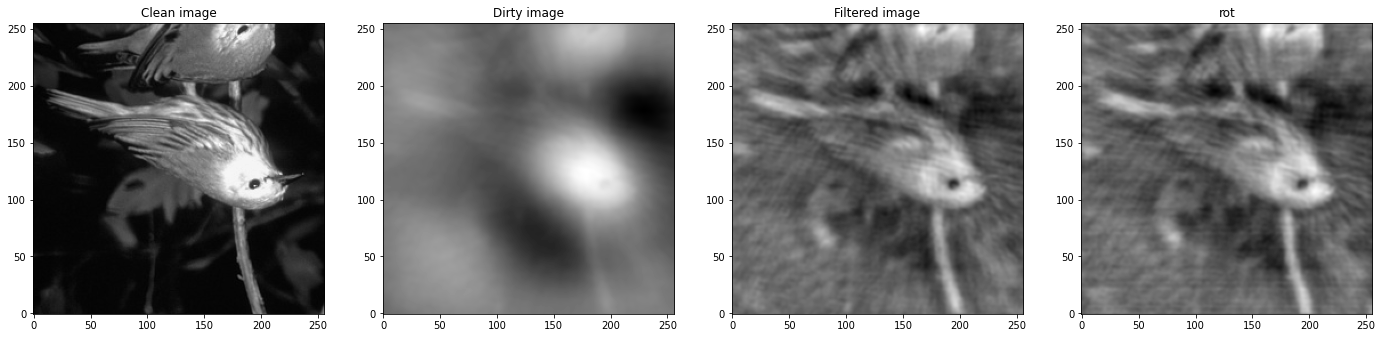

In [128]:
compare([x_true.real, x_dirty.real, x_filtered.real, x_rot.real], titles=["Clean image", "Dirty image", "Filtered image", "rot"])

In [24]:
psi = wavelet_basis(x_dirty.shape)
solver = PrimalDual_l1_constrained(m_op=m_op, psi=psi, beta=1e-2,
    options={
        'tol': 1e-4, 'iter': 5000, 'update_iter': 50, 
        'record_iters': False, 'positivity': True, 'real': True})

{'tol': 0.0001, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': True, 'real': True}


In [25]:
z, diag = solver.solve(y, m_op, noise_val)

2021-05-18 16:44:32,320 - Optimus Primal - INFO - Starting Power method
2021-05-18 16:44:32,378 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-05-18 16:44:32,613 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-05-18 16:44:32,706 - Optimus Primal - INFO - [Power Method] Converged with norm= 5.7279406, iter = 15, tol = 0.0009114753
2021-05-18 16:44:32,757 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-05-18 16:44:32,848 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.660619
2021-05-18 16:44:36,754 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.013843
2021-05-18 16:44:40,660 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.004781
2021-05-18 16:44:44,646 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.002329
2021-05-18 16:44:48,687 - Optimus Primal - INFO - [Primal Dual] 200 out of 5000 iterations, tol = 0.001610
2021-05-18 

In [79]:
compare([x_true, m_op.adj_op(y).real, z.real, x_filtered, x_true-z.real], titles=["True", "Dirty", "Reconstructed", "filtered", "Residual"])

NameError: name 'z' is not defined